In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import lightning as L

import torch

from llm_more_better.model import RewardModelLM
from llm_more_better.data import get_anthropic_rlhf_data
from llm_more_better.train_rm import parse_args

Set default arguments. I'm doing this because parse_args doesn't work in a notebook

Sidenote but is there a way to get an argparser to work in a notebook?

In [13]:
from types import SimpleNamespace

args = SimpleNamespace(
    model_name="meta-llama/Llama-3.2-1B-Instruct",
    batch_size=8,
    max_epochs=10,
    learning_rate=1e-4,
    weight_decay=0.01,
    grad_clip=1.0,
    use_lora=True,
    lora_r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    precision="bf16-true",
    seed=42,
    num_workers=4,
    accumulate_grad_batches=1,
    wandb_project="rlhf-reward-model",
    save_dir="checkpoints",
    val_check_interval=0.25,
    log_every_n_steps=10,
    disable_wandb=False
)

In [14]:
train_loader, val_loader, test_loader = get_anthropic_rlhf_data(
    batch_size=args.batch_size,
    seed=args.seed,
    num_workers=args.num_workers,
    model_name=args.model_name
)

In [15]:
model = RewardModelLM(
    model_name=args.model_name,
    learning_rate=args.learning_rate,
    weight_decay=args.weight_decay,
    num_epochs=args.max_epochs,
    use_lora=args.use_lora,
    lora_config={
        "r": args.lora_r,
        "lora_alpha": args.lora_alpha,
        "lora_dropout": args.lora_dropout,
        "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj"],
        "bias": "none",
        "task_type": "CAUSAL_LM"
    } if args.use_lora else None
)

trainable params: 1,703,936 || all params: 1,237,518,336 || trainable%: 0.1377


In [16]:
trainer = L.Trainer(
    max_epochs=args.max_epochs,
    precision=args.precision,
    gradient_clip_val=args.grad_clip,
    accelerator="auto",
    devices="auto",
    strategy="auto",
    accumulate_grad_batches=args.accumulate_grad_batches
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [17]:
from lightning.pytorch.tuner import Tuner

In [18]:
tuner = Tuner(trainer)

In [19]:
lr_finder = tuner.lr_find(model, train_loader)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 79 steps due to diverging loss.
Learning rate set to 1.5848931924611133e-07
Restoring states from the checkpoint path at /teamspace/studios/this_studio/.lr_find_40a845e3-e226-42ca-ab61-5958a689a103.ckpt
Restored all states from the checkpoint at /teamspace/studios/this_studio/.lr_find_40a845e3-e226-42ca-ab61-5958a689a103.ckpt


{'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.120108393559096e-06, 1.0964781961431852e-05, 1.3182567385564076e-05, 1.584893192461114e-05, 1.9054607179632464e-05, 2.2908676527677725e-05, 2.7542287033381663e-05, 3.311311214825911e

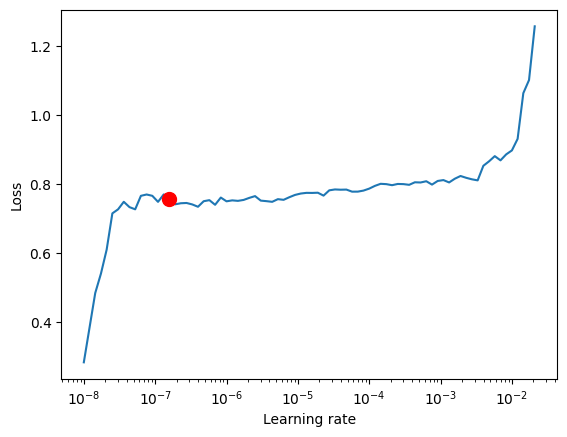

In [20]:
# Results can be found in
print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()